<a href="https://colab.research.google.com/github/FirefoxSRV/GlassClassification/blob/main/GlassClassification_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("glass.csv")
X = data.drop("Type", axis=1)
y = data["Type"]

In [7]:
print(X)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0
..       ...    ...   ...   ...    ...   ...   ...   ...  ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0

[214 rows x 9 columns]


In [8]:
print(y)

0      1
1      1
2      1
3      1
4      1
      ..
209    7
210    7
211    7
212    7
213    7
Name: Type, Length: 214, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [42]:
y_pred = classifier.predict(X_test)
y_pred = np.array(y_pred)
y_test = np.array(y_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [7 7]
 [1 1]
 [7 7]
 [2 2]
 [2 2]
 [1 1]
 [2 2]
 [2 2]
 [2 2]
 [6 6]
 [5 5]
 [2 2]
 [2 2]
 [6 6]
 [5 5]
 [7 7]
 [1 1]
 [1 1]
 [6 6]
 [2 2]
 [7 7]
 [7 7]
 [7 7]
 [2 3]
 [1 2]
 [1 1]
 [1 1]
 [2 5]
 [1 1]
 [2 1]
 [2 2]
 [1 3]
 [2 2]
 [1 1]
 [7 7]
 [5 5]
 [1 3]
 [1 2]
 [2 2]
 [1 2]
 [7 7]
 [1 1]]


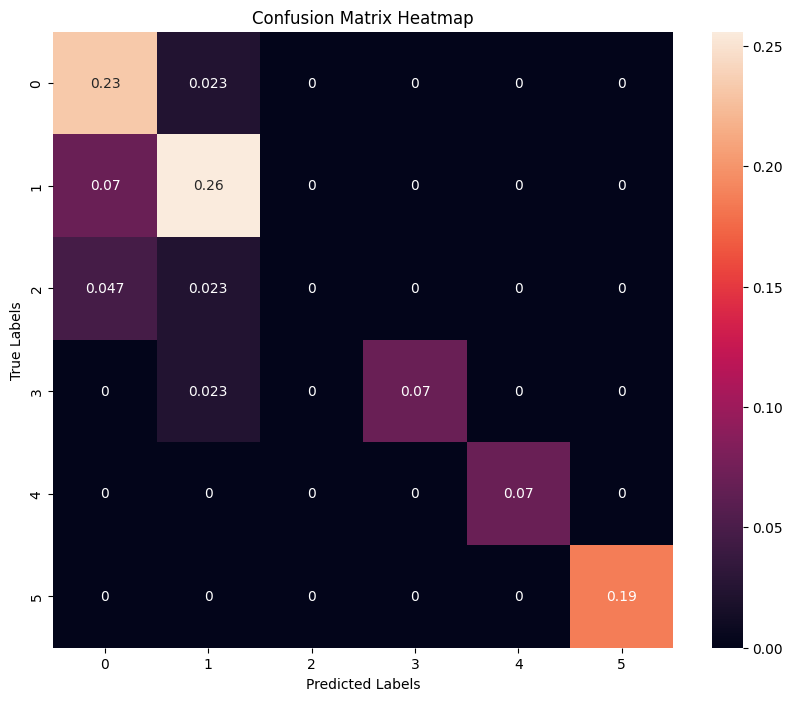

0.813953488372093

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
normalized_cm = cm / cm.sum()
sns.heatmap(normalized_cm, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
accuracy_score(y_test, y_pred)

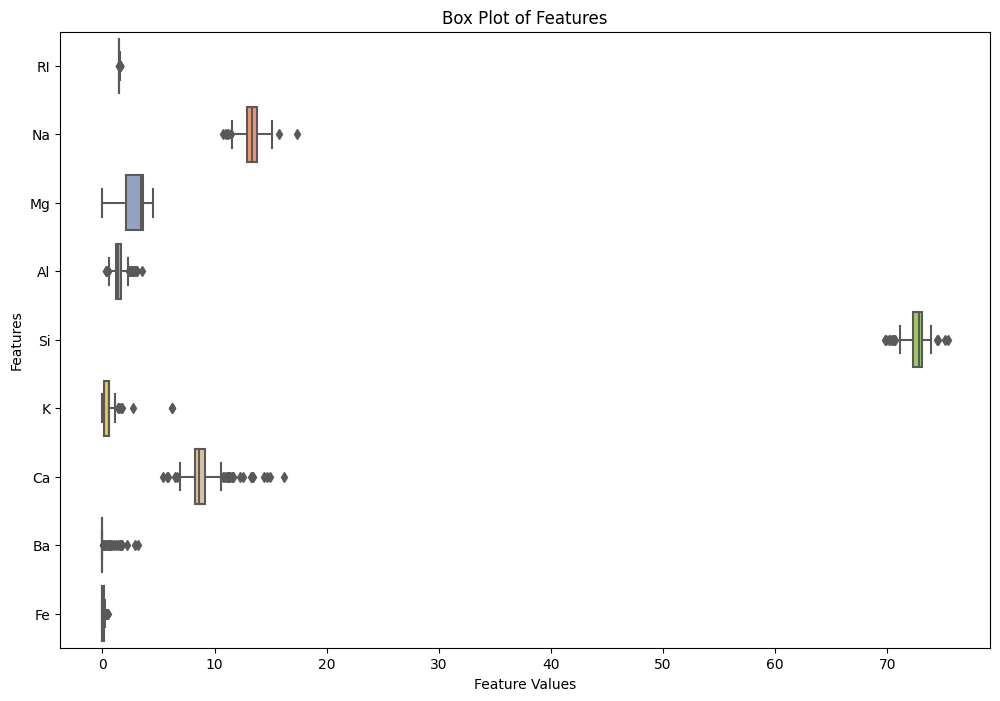

In [63]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=X, orient="h", palette="Set2")
plt.title('Box Plot of Features')
plt.xlabel('Feature Values')
plt.ylabel('Features')
plt.show()